# Ridge regression workflow for Neuroscout

This notebook implements a cross-valided voxel-wise encoding model for a single subject using Regularized Ridge Regression.

The goal is to demonstrate how to obtain Neuroscout data to fit models using custom pipelines. For a comprehensive tutorial, check out the excellent [voxelwise modeling tutorials](https://gallantlab.github.io/voxelwise_tutorials/index.html) from the Gallant Lab.

__Note__: By implementing a custom pipeline, your analysis will not be centrally registered on neuroscout.org, and a reproducible record will not be made. For analyses supported the Neuroscout-CLI (e.g. group voxel-wise mass univariate GLM models), it is recommended to use the neuroscout.org web inteface, or follow the guide for programmatically [creating analyses 
using pyNS](https://pyns.readthedocs.io/en/latest/analyses.html).

### Citing Neuroscout

If you publish any results using the Neuroscout data, be sure to cite the Neuroscout paper, and corresponding datasets:

    Alejandro de la Vega, Roberta Rocca, Ross W Blair, Christopher J Markiewicz, Jeff Mentch, James D Kent, Peer Herholz, Satrajit S Ghosh, Russell A Poldrack, Tal Yarkoni (2022). *Neuroscout, a unified platform for generalizable and reproducible fMRI research*. eLife 11:e79277. https://doi.org/10.7554/eLife.79277
    
    Visconti di Oleggio Castello, M., Chauhan, V., Jiahui, G., & Gobbini, M. I. An fMRI dataset in response to “The Grand Budapest Hotel”, a socially-rich, naturalistic movie. Sci Data 7, 383 (2020). https://doi.org/10.1038/s41597-020-00735-4

## Fetching Neuroscout Data

We can easily retrieve data from _Neuroscout_ using __pyNS__-- the Python Neuroscout API client.
Be sure to refer to the official [pyNS documentation](https://pyns.readthedocs.io/en/latest/) for further usage information, with particular focus on the section on [fetching predictors and images](https://pyns.readthedocs.io/en/latest/fetching.html).

### What data is available?

If you're not sure what is available, you can browse Neuroscout's [datasets](https://neuroscout.org/datasets) and [predictors](https://neuroscout.org/predictors) online.

Here, we were going to focus on the 'Budapest' dataset, choosing the first subject (`sid000005`) as an example. 

In [1]:
# Find first subject for Budapest
from pyns import Neuroscout

api = Neuroscout()

dataset_name = 'Budapest'

# First run for Budapest dataset
first_run = api.runs.get(dataset_name=dataset_name)[0]
subject = first_run['subject'] # Save subject name

first_run

/home/alejandro/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)


{'acquisition': None,
 'dataset_id': 27,
 'duration': 535.0,
 'id': 1435,
 'number': 3,
 'session': None,
 'subject': 'sid000005',
 'task': 48,
 'task_name': 'movie'}

### Fetching predictors 

We will fetch two sets of predictors: [Mel spetrogram](https://neuroscout.org/predictor/mel_0), and  [Mel Frequency Cepstral Coefficient (MFCC)](https://neuroscout.org/predictor/mfcc_0). Both of these features are extracted from the auditory track of the movie stimulus ('The Grand Budapest Hotel'). Later in the tutorial we'll fit an encoding model to each set of features separately, and then jointly using a banded model.

First, we define the names of the predictors we will fetch. 

To learn more about basic Neuroscout API querying, see this [guide](https://pyns.readthedocs.io/en/latest/querying.html)

In [2]:
mfccs = [f'mfcc_{i}' for i in range(20)]
mel = [f'mel_{i}' for i in range(64)]

all_vars = mfccs + mel

Next, we can use the high-level utility `fetch_predictors` to retrieve these predictors for the target subject, rescaled using unit variance, and resampled to the imaging data's Repetition Time (TR):

In [24]:
from pyns.fetch_utils import fetch_predictors

predictors = fetch_predictors(all_vars, dataset_name='Budapest', subject='sid000005', rescale=True, resample=True)

This results in a dataframe with predictors, plus meta-data such as file entities (e.g. subjects, runs)

### Fetch fMRI data and loading images

To retrieve Neuroscout data, we use `datalad` to fetch the preprocessed images remote.
pyNS includes a helper function to facilitate installing and fetching the dataset using datalad: `fetch_images`.

Provide the name of the dataset (`Budapest`), plus a directory where your datasets are stored, plus (optionally) filters to restrict which files are downloaded (e.g. subject)

In [13]:
from pyns.fetch_utils import fetch_images

preproc_dir, img_objs = fetch_images('Budapest', '/tmp/', subject=subject, fetch_brain_mask=True)

/home/alejandro/src/pybids/bids/layout/validation.py:51: UserWarning: The ability to pass arguments to BIDSLayout that control indexing is likely to be removed in future; possibly as early as PyBIDS 0.14. This includes the `config_filename`, `ignore`, `force_index`, and `index_metadata` arguments. The recommended usage pattern is to initialize a new BIDSLayoutIndexer with these arguments, and pass it to the BIDSLayout via the `indexer` argument.
  warnings.warn("The ability to pass arguments to BIDSLayout that control "
/home/alejandro/src/pybids/bids/layout/validation.py:156: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "
INFO:datalad.ui.dialog:Clear progress bars


action summary:
  get (notneeded: 10)


INFO:datalad.ui.dialog:Refresh progress bars


By default, images are loaded as pybids `BIDSImageFile` objects, which include meta-data such as entities as part of the object

In [14]:
img_objs[5].get_entities()

{'datatype': 'func',
 'desc': 'brain',
 'extension': '.nii.gz',
 'run': 1,
 'space': 'MNI152NLin2009cAsym',
 'subject': 'sid000005',
 'suffix': 'mask',
 'task': 'movie'}

Using the entities, we can separate the list of images into two lists: preprocessed functional images, and brain masks

In [15]:
all_funcs = [f for f in img_objs if f.entities['suffix'] == 'bold']
all_masks = [f for f in img_objs if f.entities['suffix'] == 'mask']

The following computes a joint mask for all runs. Alternatively, we could also provide a apriori ROI mask here.

In [16]:
import nibabel as nib
import numpy as np

def _compute_mask_intersection(masks): 
    """ Compute joint masks (i.e. where all masks have 1s)"""
    _masks = [nib.load(m) for m in masks]
    _data = np.stack(n.get_data() for n in _masks)
    
    intersection = _data.min(axis=0)
    
    mask = nib.Nifti1Image(
        intersection, affine = _masks[0].affine, header=_masks[0].header)
    
    return mask

inter_mask = _compute_mask_intersection(all_masks)

/home/alejandro/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2961: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/alejandro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  import sys


Now we can apply the corresponding brain mask to each run using `NiftiMasker` from `nilearn`, and stack them into a single array for subsequent analysis

In [17]:
import pandas as pd
import numpy as np
from nilearn.maskers import NiftiMasker

def _mask_and_stack_images(image_objects, mask):
    """ Stack images into single array, and collect metadata entities into dataframe """
    masker = NiftiMasker(mask_img=mask)

    arrays = []
    entities = []
    image_objects = sorted(image_objects, key=lambda x: x.entities['run'])
    for img in image_objects:
        run_y = masker.fit_transform(img)
        arrays.append(run_y)
        entities += [dict(img.entities)] * run_y.shape[0]
    entities = pd.DataFrame(entities)
    return np.vstack(arrays), entities, masker

In [18]:
y, img_entities, masker = _mask_and_stack_images(all_funcs, inter_mask)

The stacked runs have shape: (n_volumes, n_voxels)

In [145]:
y.shape

(3052, 123899)

## Fitting Ridge regression model using melspectrogram features

First, we'll fit a basic Ridge regression model to a subset of voxels (for demonstration purposes).

We'll define two cross-validators: an outer and an inner cv. The outer cross-validator will loop be used to estimate the performance of the model on unseen data, and the inner cv will be used to select the alpha hyperparameter for Ridge regression, within each fold of the outer cross-validator.

In both cases, we'll use the leave-one-run-out strategy, testing the model on an unseen run. Since there are multiple observations per run, we use the`run` column of `X_entities` to group observations, and ensure they appear together within each fold.

Finally, we also define a scoring function, in this case, `correlation_score`.

Note that we are using the `himalaya` library's `KernelRidgeCV` estimator, as it is optimized for multi-target (i.e. voxel) estimation & hyperparameter optimization with a sklearn-like API.

In [83]:
from himalaya.ridge import RidgeCV
from sklearn.model_selection import GroupKFold
from himalaya.scoring import correlation_score
from himalaya.backend import set_backend

backend = set_backend("torch_cuda", on_error="warn")

groups = predictors['run'].tolist()

# Set up estimator and CV objects
estimator = RidgeCV()
n_runs = len(set(groups))
cv = GroupKFold(n_splits=n_runs)
inner_cv = GroupKFold(n_splits=n_runs - 1)

/home/alejandro/anaconda3/lib/python3.7/site-packages/himalaya/backend/_utils.py:56: UserWarning: Setting backend to torch_cuda failed: PyTorch not installed..Falling back to numpy backend.
  warnings.warn(f"Setting backend to {backend} failed: {str(error)}."


The following is a generic pipeline for applying the esimator to the data (including support for banded-regression, which we'll discuss later)

In [87]:
def _model_cv(estimator, cv, X_vars, y, bands=None, groups=None,
              scoring=correlation_score,
              inner_cv=None, confounds=None, split=None):
    
    # Container for results
    results = {
        'coefficients': [],
        'test_predictions': [],
        'test_scores': []}
    
    # If confounds, stack at the end
    if confounds is not None:
        bands.append(confounds)
    
    if bands is not None:
        X = []
        for band in bands:
            X.append(X_vars[band].values)
    else:
        X = X_vars.values

    # Extract number of samples for convenience
    n_samples = y.shape[0]
    
    # Loop through outer cross-validation folds
    for train, test in cv.split(np.arange(n_samples), groups=groups):
        
        # Get training model for list of model bands
        X_train = [x[train] for x in X] if type(X) == list else X[train]
        X_test = [x[test] for x in X] if type(X) == list else X[test]
        
        # Create inner cross-validation loop if specified
        if inner_cv:
            # Split inner cross-validation with groups if supplied
            inner_groups = np.array(groups)[train] if groups else groups
            inner_splits = inner_cv.split(np.arange(n_samples)[train],
                                          groups=inner_groups)
            
            # Update estimator with inner cross-validator
            estimator.set_params(cv=inner_splits)
        
        # Fit the regression model on training data
        estimator.fit(X_train, y[train])
        
        # Zero out coefficients for confounds if provided
        if confounds is not None:
            estimator.coef_[-len(confounds):] = 0
        
        # Compute predictions with optional splitting by band
        kwargs = {}
        if split is not None:
            kwargs['split'] = split
        test_prediction = estimator.predict(X_test, **kwargs)
        
        # Test scores should also optionally split by band
        test_score = scoring(y[test], test_prediction)
        
        # Populate results dictionary
#         results['coefficients'].append(estimator.dual_coef_)
        results['test_predictions'].append(test_prediction)
        results['test_scores'].append(test_score)
        
    # Combine into single aray
    results['coefficients'] = np.stack(results['coefficients'])
    results['test_scores'] = np.stack(results['test_scores'])
    
    return results

First, we'll fit this model using only the mel-spectrogram features:

In [88]:
X = predictors[mel]
results = _model_cv(estimator, cv, X, y, inner_cv=inner_cv, groups=groups)

/home/alejandro/anaconda3/lib/python3.7/site-packages/himalaya/kernel_ridge/_sklearn_api.py:494: UserWarning: Solving linear kernel ridge is slower than solving ridge when n_samples > n_features (here 2249 > 64). Using himalaya.ridge.RidgeCV would be faster. Use warn=False to silence this warning.
  "Use warn=False to silence this warning.", UserWarning)
/home/alejandro/anaconda3/lib/python3.7/site-packages/himalaya/kernel_ridge/_sklearn_api.py:494: UserWarning: Solving linear kernel ridge is slower than solving ridge when n_samples > n_features (here 2434 > 64). Using himalaya.ridge.RidgeCV would be faster. Use warn=False to silence this warning.
  "Use warn=False to silence this warning.", UserWarning)
/home/alejandro/anaconda3/lib/python3.7/site-packages/himalaya/kernel_ridge/_sklearn_api.py:494: UserWarning: Solving linear kernel ridge is slower than solving ridge when n_samples > n_features (here 2454 > 64). Using himalaya.ridge.RidgeCV would be faster. Use warn=False to silence t

ValueError: all input arrays must have the same shape

### Results

The `result` dictionary contains:

In [147]:
print(results.keys())

dict_keys(['coefficients', 'test_predictions', 'test_scores'])


The `test_scores` & coefficients are of shape: (n_folds, n_voxels).

In [148]:
results['test_scores'].shape

(5, 123899)

We can average across folds, and only take positive scores:

In [194]:
mean_scores = results['test_scores'].mean(axis=0)
mean_scores[mean_scores < 0] = 0

In [195]:
mean_scores.max()

0.17239105274654085

In [196]:
mean_scores.mean()

0.013437605362038522

We can inverse transform the score map, to a 3D volume, and vizualize it:

In [52]:
from nilearn.plotting import plot_stat_map

plot_stat_map(masker.inverse_transform(mean_scores), display_mode='z')

### Ridge regression using MFCC features

We can now run a similar model, but using MFCC featues, instead of the mel-spectrogram

In [188]:
X = predictors[mfccs]
results_mfcc = _model_cv(estimator, cv, X, y, inner_cv=inner_cv, groups=groups)

In [190]:
mean_scores_mfcc = results_mfcc['test_scores'].mean(axis=0)
mean_scores_mfcc[mean_scores_mfcc < 0] = 0

From looking at whole-brain scores, the MFCC model outperforms the mel-spectrogram model

In [191]:
mean_scores_mfcc.max()

0.3147913597910006

In [193]:
mean_scores_mfcc.mean()

0.02529379029622442

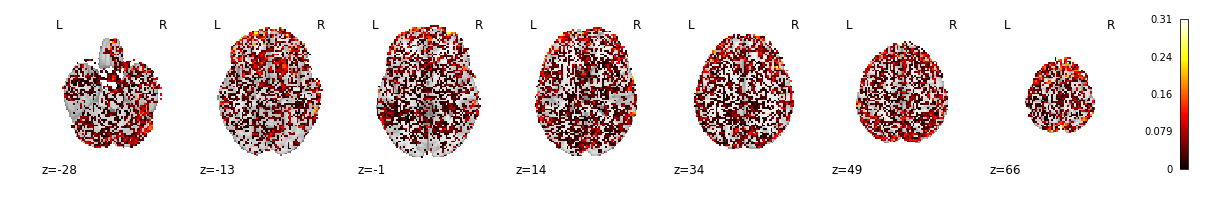

In [199]:
from nilearn.plotting import plot_stat_map, plot_glass_brain

plot_stat_map(masker.inverse_transform(mean_scores_mfcc), display_mode='z')

## Finite impulse response model

Due to the hemodynamic response lag, it's likely the model would perform better if the predictors were delayed.

We can do so using a Finite Impulse Response (fir) model. 

Using `fetch_predictors`, we can ask for the predictors to be returned as a `BIDSVariableCollection`, which enables us to apply any of the transformations implemented in pybids. Alternatively, you could apply any transformations manually, by declining to re-sample the predictors to TR, and applying transformations manually 

In [10]:
collection = fetch_predictors(all_vars, dataset_name='Budapest', subject='sid000005', return_type='collection')

In [67]:
from bids.modeling.transformations import Scale, Convolve


def _convolve_resample(collection, predictor_names):
    # Resample to TR
    collection = collection.to_dense().resample('TR')
    
    Convolve(collection, predictor_names, model='fir', fir_delays=[1, 2, 3, 4])

    collection = collection.to_df()

    # Sort rows by keys
    sort_keys = [a for a in ['subject', 'session', 'run', 'acquisition', 'onset'] if a in collection.columns]
    collection = collection.sort_values(sort_keys)

    # Reorder columns
    sort_columns = ['onset', 'duration'] + predictor_names
    sort_columns += collection.columns.difference(sort_columns).tolist()
    collection = collection[sort_columns]
    
    return collection

collection_df = _scale_convolve_resample(collection, all_vars)

In [68]:
collection_df.shape

(3052, 425)

The FIR convolution results in 5x amount of predictors, including the delayed version of the predictors.

We can now fit a model with all the mel-spectrogram features, to see if that improves prediction

In [69]:
X = collection_df.iloc[:, collection_df.columns.str.startswith('mel')]
results_mel_fir = _model_cv(estimator, cv, X, y, inner_cv=inner_cv, groups=groups)

In [70]:
mean_scores_mel_fir = results_mel_fir['test_scores'].mean(axis=0)
mean_scores_mel_fir[mean_scores_mel_fir < 0] = 0

The max score increases, while the mean score remains similar

In [71]:
mean_scores_mel_fir.max()

0.20443250657787004

In [72]:
mean_scores_mel_fir.mean()

0.013157799031659837

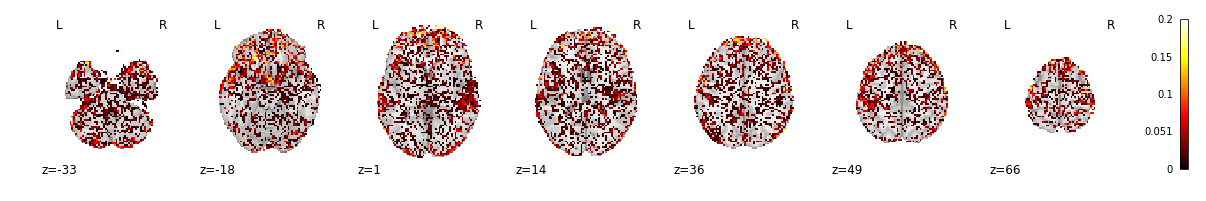

In [73]:
plot_stat_map(masker.inverse_transform(mean_scores_mel_fir), display_mode='z')

### FIR model with MFCC features

In [74]:
X = collection_df.iloc[:, collection_df.columns.str.startswith('mfcc')]
results_mfcc_fir = _model_cv(estimator, cv, X, y, inner_cv=inner_cv, groups=groups)

In [75]:
results_mfcc_fir = results_mfcc_fir['test_scores'].mean(axis=0)
results_mfcc_fir[results_mfcc_fir < 0] = 0

In [76]:
results_mfcc_fir.max()

0.3044056958957576

In [77]:
results_mfcc_fir.mean()

0.012866988759773148

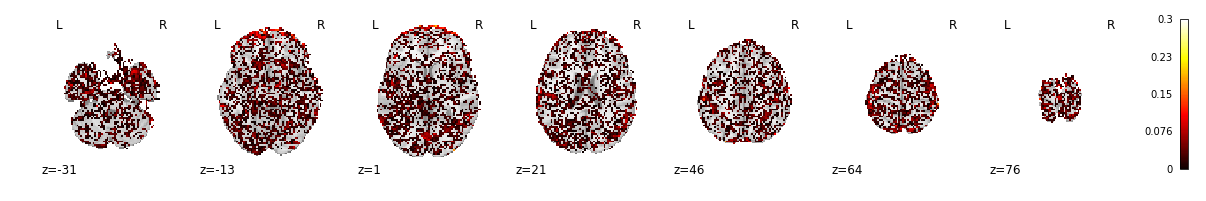

In [78]:
plot_stat_map(masker.inverse_transform(results_mfcc_fir), display_mode='z')

### Banded model with both mel and MFCC

In [93]:
from himalaya.kernel_ridge import MultipleKernelRidgeCV

In [ ]:
estimator = MultipleKernelRidgeCV()
X = collection_df.iloc[:, collection_df.columns.str.startswith('m')]

results_combined = _model_cv(estimator, cv, X, y, inner_cv=inner_cv, groups=groups)

[........................................] 100% | 1531.43 sec | 100 random sampling with cv | 
[........................................] 100% | 1785.78 sec | 100 random sampling with cv | 
[........................................] 100% | 1788.09 sec | 100 random sampling with cv | 
[.................                       ] 43% | 859.27 sec | 100 random sampling with cv | 